In [1]:
import torch
import torch.nn as nn
import numpy as np

from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
model_name = 'google/bert_uncased_L-4_H-512_A-8'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [4]:
MAX_LENGTH = 128
BATCH_SIZE = 32

dataset = load_dataset('glue', 'qnli')

def tokenize(data):
    return tokenizer(data['sentence'], truncation=True, max_length=MAX_LENGTH, padding='max_length')

tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=5000)

def create_dataloader(dataset, batch_size):
    input_ids = torch.tensor(dataset['input_ids'])
    attention_masks = torch.tensor(dataset['attention_mask'])
    labels = torch.tensor(dataset['label'])
    tensor_dataset = TensorDataset(input_ids, attention_masks, labels)
    random_sampler = RandomSampler(tensor_dataset)
    return DataLoader(tensor_dataset, sampler=random_sampler, batch_size = batch_size)

train_data_loader = create_dataloader(tokenized_dataset['train'], BATCH_SIZE)
test_data_loader = create_dataloader(tokenized_dataset['validation'], BATCH_SIZE)

Found cached dataset glue (C:/Users/yeti/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/104743 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [5]:
import sys
import os
sys.path.append(os.path.relpath(".."))

from utils import train_model, evaluate_model, draw_activation, draw_weight, replace_modules

In [6]:
model.to('cuda')
# model.train()

# train_model(model, train_data_loader, device=torch.device('cuda'), epochs=10)
# torch.save(model, "./bert-small_qnli.pt")

model = torch.load("./bert-small_qnli.pt")

c:\Users\yeti\anaconda3\envs\py309\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 --- training model
100% 1/10 - elapsed: 0:07:25, average train loss: 0.6553501385464927
100% 2/10 - elapsed: 0:06:48, average train loss: 0.6327849717022227
100% 3/10 - elapsed: 0:06:52, average train loss: 0.6032768606265726
100% 4/10 - elapsed: 0:06:42, average train loss: 0.5693957032630119
100% 5/10 - elapsed: 0:06:35, average train loss: 0.5381250876749006
100% 6/10 - elapsed: 0:06:32, average train loss: 0.512128888750557
100% 7/10 - elapsed: 0:06:39, average train loss: 0.4894658296563018
100% 8/10 - elapsed: 0:06:05, average train loss: 0.4720263573896907
100% 9/10 - elapsed: 0:06:25, average train loss: 0.45634478757529995
100% 10/10 - elapsed: 0:07:02, average train loss: 0.44579250657238023
 --- train finished, elapsed: 1:07:09


In [7]:
model.eval()
evaluate_model(model, test_data_loader, torch.device('cuda'))

100% f1: 0.5801781737193764, evaluating loss: 0.8263
 3201 / 5463 
 --- evaluation finished 0:00:07


In [8]:
class ObserverLinear(nn.Module):
  def __init__(self, linear):
    super(ObserverLinear, self).__init__()
    self.linear = linear
    self.channel_max = np.ones(linear.in_features) * 1e-8

  def observe(self, x):
    x_channel_max = np.abs(x.detach().cpu().numpy()).max(axis=0).max(axis=0)
    self.channel_max = np.maximum(self.channel_max, x_channel_max)

  def forward(self, x):
    self.observe(x)
    return self.linear(x)



def quantize(n_bits, x):
  x_max = x.max()
  x_min = x.min()
  x_scale = (x_max - x_min) / (2 ** n_bits - 1)
  x_zero_point = torch.round((x_max*-(2 ** n_bits) - x_min*(2 ** n_bits - 1))/(x_max - x_min))
  x_q = (torch.round(x/x_scale) + x_zero_point)
  return x_q, x_scale, x_zero_point


class FakeInt8Linear(nn.Module):
  def __init__(self, linear):
    super(FakeInt8Linear, self).__init__()

    self.in_features = linear.in_features
    self.out_features = linear.out_features
    self.bit_width = 8
    
    weight, scale, zero_point = self.quantize(linear.weight.detach())
    self.register_buffer("scale", scale)
    self.register_buffer("zero_point", zero_point)
    self.register_buffer("weight", weight)
    self.register_buffer("bias", linear.bias)
    # self.bias = linear.bias

  def quantize(self, x):
    x_max = x.max()
    x_min = x.min()
    x_scale = (x_max - x_min) / (2 ** 8 - 1)
    x_zero_point = torch.round((x_max*-128 - x_min*127)/(x_max - x_min))
    x_q = (torch.round(x/x_scale) + x_zero_point)
    return x_q, x_scale, x_zero_point

  def forward(self, x):
    x_q, x_scale, x_zero_point = self.quantize(x)
    scale = x_scale * self.scale
    output = torch.functional.F.linear(x_q - x_zero_point, self.weight - self.zero_point, torch.round(self.bias / scale))
    # output = torch.matmul(x_q - x_zero_point, self.weight.T - self.zero_point)
    output = output * (x_scale * self.scale)
    # output = output + self.bias
    return output
  
class SmoothLinear(nn.Module):
  def __init__(self, linear, act_scale, alpha = 0.5, n_bits = 8):
    super(SmoothLinear, self).__init__()
    
    weight = linear.weight.detach()
    w_abs_max = torch.max(torch.abs(weight), dim=0)[0]
    smooth_scale = torch.pow(act_scale, alpha) / torch.pow(w_abs_max, 1-alpha)
    w_q, w_scale, w_zero_point = quantize(8, smooth_scale * weight)

    self.register_buffer("n_bits", n_bits)
    self.register_buffer("weight", w_q)
    self.register_buffer("scale", w_scale)
    self.register_buffer("zero_point", w_zero_point)
    self.register_buffer("smooth_scale", smooth_scale)
    self.register_buffer("bias", linear.bias)
    self.draw = False

  def quantize(self, x):
    x_max = x.max()
    x_min = x.min()
    x_scale = (x_max - x_min) / (2 ** self.n_bits - 1)
    x_zero_point = torch.round((x_max*-(2 ** self.n_bits) - x_min*(2 ** self.n_bits - 1))/(x_max - x_min))
    x_q = (torch.round(x/x_scale) + x_zero_point)
    return x_q, x_scale, x_zero_point

  def forward(self, x):
    
    smoothed = x / self.smooth_scale

    if self.draw:
      draw_activation(x)
      draw_activation(smoothed)
      self.draw = False

    x_q, x_scale, x_zero_point = self.quantize(8, smoothed)
    scale = x_scale * self.scale
    output = torch.functional.F.linear(x_q - x_zero_point, self.weight - self.zero_point, torch.round(self.bias / scale))
    output = output * scale
    return output
    
    

In [9]:
from copy import deepcopy

def replace_modules(model, from_class, to_class):
    for name, module in model.named_children():
        if isinstance(module, from_class):
            target_object = to_class(module)
            setattr(model, name, target_object)
        else:
            replace_modules(module, from_class, to_class)

observer_model = deepcopy(model)
replace_modules(observer_model.bert, nn.Linear, ObserverLinear)

# observe activation
target_layer = observer_model.bert.encoder.layer[3].attention.self.query

reference = {
    "last_activation": None
}

def pre_forward_hook(module, x):
    reference["last_activation"] = x[0].detach().to('cpu')

target_layer.register_forward_pre_hook(pre_forward_hook)

In [10]:
observer_model.to('cuda')
observer_model.eval()

evaluate_model(observer_model, test_data_loader)

100% f1: 0.5801781737193764, evaluating loss: 0.8256
 3201 / 5463 
 --- evaluation finished 0:00:43


In [11]:
# draw_activation(reference["last_activation"][0])
# draw_weight(target_layer.linear.weight)

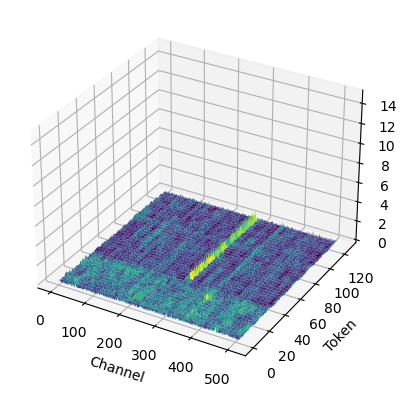

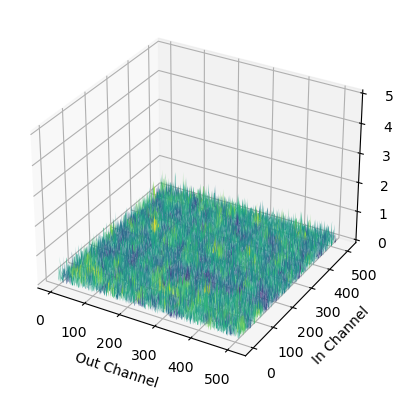

In [12]:
target_activation = reference["last_activation"][0]
target_weight = target_layer.linear.weight.detach().to('cpu')
alpha = 0.5
max_X = torch.tensor(target_layer.channel_max)
max_W = torch.max(torch.abs(target_weight), dim=0)[0]
scale = max_X.pow(alpha) / max_W.pow(1 - alpha)


# activation_sorted = torch.sort(torch.abs(torch.mean(target_activation, dim=0)), descending=True)
# print(activation_sorted.indices[:5])
# print(activation_sorted.values[:5])

# channel_max_sorted = torch.tensor(target_layer.channel_max)
# channel_max_sorted = torch.sort(channel_max_sorted, descending=True)
# print(channel_max_sorted.indices[:5])
# print(channel_max_sorted.values[:5])
# print(target_layer.channel_max[276])

# print(target_weight.shape)

draw_activation(target_activation / scale, scale=15)
draw_weight(scale * target_weight)

In [13]:
evaluate_model(model, test_data_loader)

smooth_model = deepcopy(observer_model)
smooth_model.to('cpu')

def observer_to_smooth(observer):
    return SmoothLinear(observer.linear, torch.tensor(observer.channel_max, dtype=torch.float32), alpha=0.5)
replace_modules(smooth_model, ObserverLinear, observer_to_smooth)

last_layer = smooth_model.bert.encoder.layer[3].attention.self.value
last_layer.draw = True

smooth_model.eval()
evaluate_model(smooth_model, test_data_loader)

custom_model = deepcopy(model)
replace_modules(custom_model, nn.Linear, FakeInt8Linear)
custom_model.eval()
evaluate_model(custom_model, test_data_loader)

100% f1: 0.5801781737193764, evaluating loss: 0.8265
 3201 / 5463 
 --- evaluation finished 0:00:07
100% f1: 0.5737396538750941, evaluating loss: 0.8206
 3197 / 5463 
 --- evaluation finished 0:00:12
100% f1: 0.5753169276659209, evaluating loss: 0.8187
 3185 / 5463 
 --- evaluation finished 0:00:12


In [14]:
model.eval()
model.to('cpu')
q_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
evaluate_model(q_model, test_data_loader, torch.device('cpu'))

100% f1: 0.5705637533106318, evaluating loss: 0.8334
 3193 / 5463 
 --- evaluation finished 0:01:33
